In [31]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime

from statsmodels.stats import proportion

from psyfun import io, atlas, spikes
from psyfun.config import paths, cmaps

In [2]:
# Load the session and unit metadata
df_sessions = pd.read_csv(paths['sessions'])  # session info
df_sessions = io.add_postLSD_epochs(df_sessions)
df_units = pd.read_parquet(paths['units'])  # unit info

In [3]:
## TODO: need to know which session are control from new recordings
# df_sessions['n_tasks'] = df_sessions.apply(lambda x: sum(['Choice' in tp for tp in x['task_protocol'].split('/')]), axis='columns')
df_sessions['year'] = df_sessions['start_time'].apply(lambda x: datetime.fromisoformat(x).year)
df_sessions = df_sessions.query('year < 2025')

In [7]:
# Get eids for sessions with both tasks
df_sessionquery = df_sessions.query('n_tasks == 2')
eids = df_sessionquery['eid'].tolist()

# Find good-quality units from those sessions
df_unitquery = df_units.query('eid in @eids and ks2_label == "good"')
# Load spike times for good units
uuids = df_unitquery['uuid'].tolist()
df_spiketimes = io.load_units(paths['spikes'], uuids)
# Join spike times with unit info
df_spikes = df_unitquery.set_index('uuid').join(df_spiketimes).reset_index()

# Merge session info into spikes dataframe
df_spikes = pd.merge(df_spikes, df_sessionquery, on=['subject', 'eid', 'session_n'], how='left')
# Clean up columns
df_spikes = df_spikes[[col for col in df_spikes.columns if not col.endswith('_x') or col.endswith('_y')]]

100%|█████████████████████████████████████| 9697/9697 [00:02<00:00, 4043.01it/s]


In [8]:
epochs = ['task00_spontaneous', 'LSD0', 'LSD600', 'LSD1200', 'task01_spontaneous']
dt = 1  # get spike counts in 1s bins

for epoch in epochs:
    print(f"Getting spike counts for: {epoch}")
    df_spikes[f'{epoch}_counts'] = df_spikes.progress_apply(spikes._get_spike_counts, epoch=epoch, dt=dt, axis='columns')
    df_spikes[f'{epoch}_rate'] = df_spikes[f'{epoch}_counts'].apply(lambda x: (x / dt).mean())

Getting spike counts for: task00_spontaneous


100%|█████████████████████████████████████| 9697/9697 [00:03<00:00, 2965.12it/s]


Getting spike counts for: LSD0


100%|█████████████████████████████████████| 9697/9697 [00:03<00:00, 2997.89it/s]


Getting spike counts for: LSD600


100%|█████████████████████████████████████| 9697/9697 [00:03<00:00, 3141.61it/s]


Getting spike counts for: LSD1200


100%|█████████████████████████████████████| 9697/9697 [00:03<00:00, 3066.06it/s]


Getting spike counts for: task01_spontaneous


100%|█████████████████████████████████████| 9697/9697 [00:02<00:00, 3264.06it/s]


/home/crombie/miniconda3/envs/iblenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log(rate)')

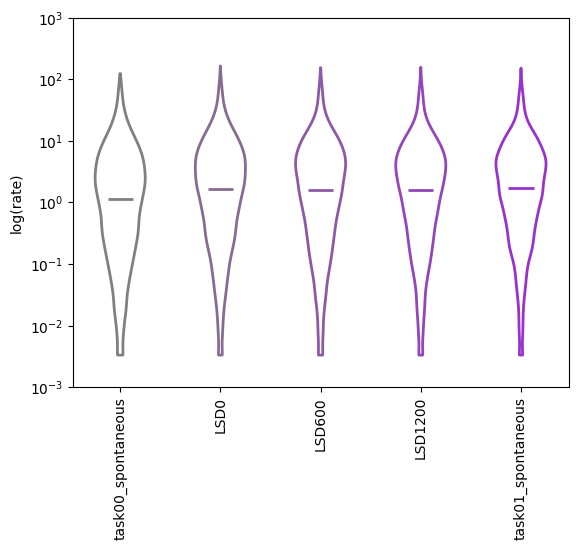

In [6]:
fig, ax = plt.subplots()
cmap = cmaps['LSD']
colors = cmap(np.linspace(0, 1, len(epochs))) 

xpos = np.arange(len(epochs))
rates = [np.log10(df_spikes[f'{epoch}_rate']).replace(-np.inf, np.nan).dropna() for epoch in epochs]

violins = ax.violinplot(rates, positions=xpos, showmedians=True, showextrema=False)
for violin, color in zip(violins['bodies'], colors):
    violin.set_facecolor('none')
    violin.set_edgecolor(color)
    violin.set_linewidth(2)
    violin.set_alpha(1)
violins['cmedians'].set_edgecolor(colors)
violins['cmedians'].set_linewidth(2)
ax.set_xticks(xpos)
ax.set_xticklabels(epochs)
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.linspace(-3, 3, 7))
ax.set_yticklabels(['$10^{%d}$' % tick for tick in np.linspace(-3, 3, 7)])
ax.set_ylabel('log(rate)')

In [9]:
from scipy import stats

KruskalResult(statistic=np.float64(217.63971858269318), pvalue=np.float64(6.036934602432311e-46))

In [25]:
print(stats.kruskal(*[r.values for r in rates]), '\n')

print("MannWhitneyU pair-wise comparisons:")
results = []
for i in range(len(epochs)):
    for j in range(i + 1, len(epochs)):
        u_stat, p_value = stats.mannwhitneyu(rates[i].values, rates[j].values)
        results.append({
            'Epoch 1': epochs[i],
            'Epoch 2': epochs[j],
            'U Statistic': u_stat,
            'p-value': p_value
        })

df_results = pd.DataFrame(results)
print(df_results)

KruskalResult(statistic=np.float64(217.63971858269318), pvalue=np.float64(6.036934602432311e-46)) 

MannWhitneyU pair-wise comparisons:
              Epoch 1             Epoch 2  U Statistic       p-value
0  task00_spontaneous                LSD0   38047166.0  1.033823e-27
1  task00_spontaneous              LSD600   38013597.5  1.034261e-23
2  task00_spontaneous             LSD1200   37858474.0  2.950588e-23
3  task00_spontaneous  task01_spontaneous   37265202.5  9.326466e-44
4                LSD0              LSD600   42242733.5  4.390603e-01
5                LSD0             LSD1200   42129114.0  2.989976e-01
6                LSD0  task01_spontaneous   41695218.0  8.644319e-03
7              LSD600             LSD1200   41493320.0  7.729599e-01
8              LSD600  task01_spontaneous   41063579.5  7.932970e-04
9             LSD1200  task01_spontaneous   40746824.5  2.432484e-04


In [27]:
# Get firig rate modulation index
epochs = ['task00_spontaneous', 'task01_spontaneous']

df_spikes['MI'] = df_spikes.progress_apply(spikes._get_modulation_index, epochs=epochs, axis='columns')
df_spikes['MI_p'] = df_spikes['MI'].apply(lambda x: x[1])
df_spikes['MI'] = df_spikes['MI'].apply(lambda x: x[0])

columns_to_keep = [
    'uuid', 'eid', 'subject', 'n_probes', 'n_tasks', 'start_time', 
    'amp_median', 'contamination', 'drift', 'label', 
    'x', 'y', 'z', 'region', 
    'MI', 'MI_p'
]
df_spikes[columns_to_keep].to_parquet('data/singleunit_MI.pqt')

  0%|▌                                                                                                                             | 47/9697 [00:03<12:14, 13.14it/s]/home/crombie/code/ibl_psychedelics/psyfun/spikes.py:24: RuntimeWarning: invalid value encountered in divide
  return np.squeeze(np.diff(rates, axis=0) / np.sum(rates, axis=0))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9697/9697 [07:51<00:00, 20.57it/s]


In [26]:
df_spikes = pd.read_parquet('data/singleunit_MI.pqt')

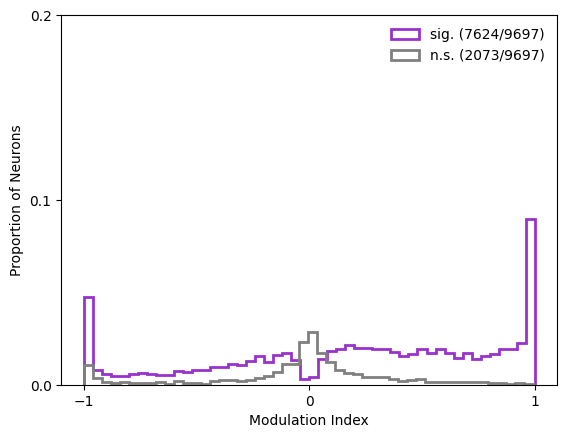

In [27]:
fig, ax = plt.subplots()

queries = [
    'MI_p <= 0.025 or MI_p >= 0.975',
    'MI_p > 0.025 and MI_p < 0.975'
]
cmap = cmaps['LSD']
colors = [cmap(1.), cmap(0.)]

for query, color, label in zip(queries, colors, ['sig.', 'n.s.']):
    df = df_spikes.query(query)
    weights = np.ones(len(df)) / len(df_spikes)
    label = f'{label} ({len(df)}/{len(df_spikes)})'
    ax.hist(df['MI'], bins=50, weights=weights, histtype='step', linewidth=2, color=color, label=label)

ax.set_xticks([-1, 0, 1])
ax.set_xlabel('Modulation Index')
ax.set_yticks([0, 0.1, 0.2])
ax.set_ylabel('Proportion of Neurons')
ax.legend(loc='upper right', frameon=False)

In [28]:
# Make a df only with units mapped to a region
# df_regions = df_spikes.dropna(subset='region').copy()
df_regions = df_spikes.replace({'region': {None: 'root'}}).copy()
# Merge region acronyms into coarse regions
df_regions['coarse_region'] = atlas.combine_regions(df_regions['region'])
df_regions = df_regions.query('region != "root"')

/tmp/ipykernel_7684/1409206590.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.bar(xpos, MIs[sorted_inds], yerr=yerr[:, sorted_inds], fc=colors[sorted_inds], ec='gray')


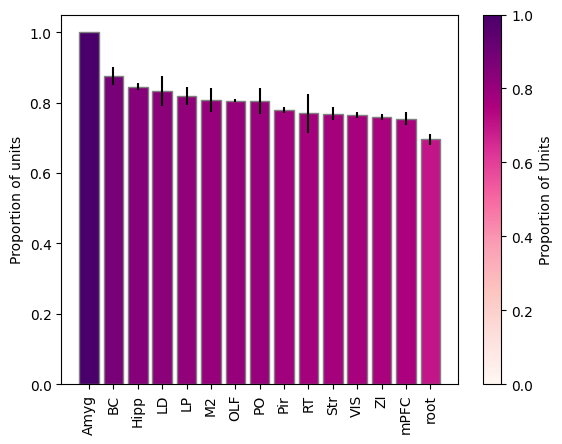

In [33]:
fig, ax = plt.subplots()
n_regions = 50

# Count neurons per region-eid
n_neurons = df_regions.groupby('coarse_region').size()

# Count neurons with significant modualtion (2-sided test) per region-eid
n_significant = df_regions.query('MI_p < 0.025 or MI_p > 0.975').groupby('coarse_region').size()

# Proportion of significant neurons
MI_props = (n_significant / n_neurons).reset_index(name='MI_prop')  # .query('coarse_region != "root"')
MI_regions = MI_props.groupby('coarse_region')['MI_prop']

MIs = MI_regions.mean()
y_neg, y_pos = proportion.proportion_confint(n_significant, n_neurons, alpha=0.5)
yerr = np.vstack([MIs - y_neg, y_pos - MIs])
n_sessions = MI_regions.size()
sorted_inds = np.argsort(-1 * MIs)
xpos = np.arange(len(MIs))

cmap = cmaps['n_units']
colors = np.array([cmap(p) for p in MIs / MIs.max()])

ax.bar(xpos, MIs[sorted_inds], yerr=yerr[:, sorted_inds], fc=colors[sorted_inds], ec='gray')
ax.set_xticks(np.arange(len(MIs)))
ax.set_xticklabels(MIs.index)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Proportion of units')

mappable = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, MIs.max()), cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, label='Proportion of Units')

Text(0, 0.5, 'Mean MI')

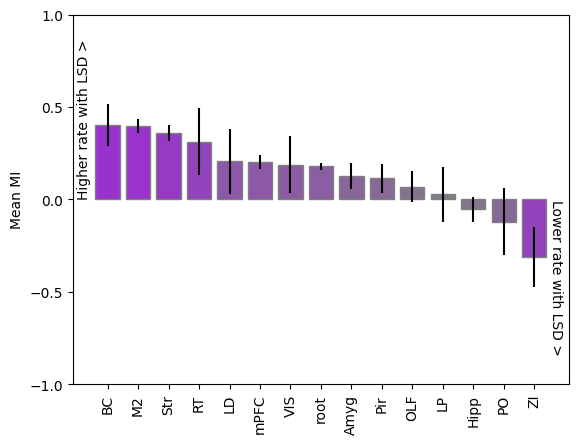

In [64]:
fig, ax = plt.subplots()

regions = df_regions.query('MI_p < 0.025 or MI_p > 0.975').groupby('coarse_region')
MIs = regions['MI'].mean()
yerr = regions['MI'].sem() * 1.96
sorted_inds = np.argsort(-1 * MIs)
xpos = np.arange(len(MIs))

cmap = cmaps['LSD']
colors = np.array([cmap(p) for p in np.abs(MIs) / np.abs(MIs).max()])

ax.bar(xpos, MIs.iloc[sorted_inds], yerr=yerr.iloc[sorted_inds], fc=colors[sorted_inds], ec='gray')
ax.text(xpos[0] - 1, 0, 'Higher rate with LSD >', va='bottom', rotation=90)
ax.text(xpos[-1] + 0.5, 0, 'Lower rate with LSD >', va='top', rotation=270)
ax.set_xticks(np.arange(len(MIs)))
ax.set_xticklabels(MIs.index[sorted_inds])
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.linspace(-1, 1, 5))
ax.set_ylabel('Mean MI')

In [54]:
def bootstrap_median_ci(data, n_bootstrap=1000, alpha=0.05):
    """
    Compute a bootstrap confidence interval for the median of an array.
    
    Parameters
    ----------
    data : array_like
        The data from which to compute the median.
    n_bootstrap : int, optional
        The number of bootstrap samples to use. Default is 1000.
    alpha : float, optional
        Significance level (e.g. 0.05 gives a 95% CI).
        
    Returns
    -------
    (ci_lower, ci_upper) : tuple of floats
        The lower and upper bounds of the bootstrap confidence interval.
    """
    medians = np.empty(n_bootstrap)
    n = len(data)
    for i in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        medians[i] = np.median(sample)
    ci_lower = np.percentile(medians, 100 * (alpha / 2))
    ci_upper = np.percentile(medians, 100 * (1 - alpha / 2))
    return ci_lower, ci_upper

Text(0, 0.5, 'Modulation Index')

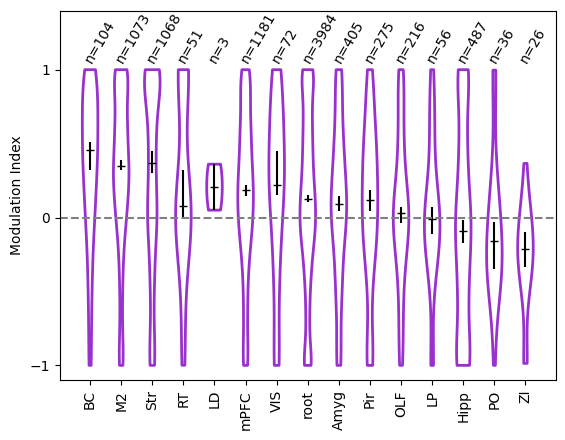

In [83]:
fig, ax = plt.subplots()
cmap = cmaps['LSD']

xpos = np.arange(len(MIs))
region_labels = np.array(list(regions.groups.keys()))
MIs = [region['MI'].dropna().values for _, region in regions]
# sorted_inds = np.argsort([np.median(MI) for MI in MIs])
sorted_MIs = [MIs[i] for i in sorted_inds]
cis = [bootstrap_median_ci(mi) for mi in sorted_MIs]

violins = ax.violinplot(sorted_MIs, positions=xpos, showmedians=False, showextrema=False)
for violin in violins['bodies']:
    violin.set_facecolor('none')
    violin.set_edgecolor(cmap(1.))
    violin.set_linewidth(2)
    violin.set_alpha(1)
for i, (mi, (ci_lower, ci_upper)) in enumerate(zip(sorted_MIs, cis)):
    med = np.median(mi)
    ax.errorbar(xpos[i], med, yerr=[[med - ci_lower], [ci_upper - med]], fmt='_', color='black')
ax.axhline(0, ls='--', color='gray')
for x, units in zip(xpos, sorted_MIs):
    ax.text(x - 0.25, 1.05, f'n={len(units)}', rotation=60)
ax.set_xticks(xpos)
ax.set_xticklabels(region_labels[sorted_inds])
ax.tick_params(axis='x', rotation=90)
ax.set_yticks([-1, 0, 1])
ax.set_ylim([-1.1, 1.4])
ax.set_ylabel('Modulation Index')

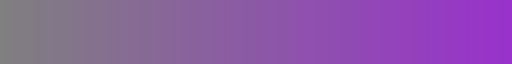

In [101]:
cmap

In [27]:
# df_units_bwm = pd.read_csv('data/BWM_units.csv')